# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [399]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [228]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

analytic_grad_at_ix =  6.0
numeric_grad_at_ix =  6.000000000039306
Gradient check passed!
analytic_grad_at_ix =  1.0
numeric_grad_at_ix =  0.9999999999621422
analytic_grad_at_ix =  1.0
numeric_grad_at_ix =  0.9999999999621422
Gradient check passed!
analytic_grad_at_ix =  1.0
numeric_grad_at_ix =  0.9999999999621422
analytic_grad_at_ix =  1.0
numeric_grad_at_ix =  0.9999999999621422
analytic_grad_at_ix =  1.0
numeric_grad_at_ix =  0.9999999999621422
analytic_grad_at_ix =  1.0
numeric_grad_at_ix =  0.9999999999621422
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [238]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [7]:
probs = linear_classifer.softmax(np.array([ -5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, np.array([1]))

softmax =  [4.50940412e-05 6.69254912e-03 9.93262357e-01]
cross_entropy_loss =  [5.00676044]


array([5.00676044])

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [243]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), np.array([1]))

check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array([1])), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [322]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3


predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)

print ("__________________________", target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)
    

    
# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]],dtype=np.float64))
assert np.all(np.isclose(probs[:, 0], 1.0))

analytic_grad = [[ 0.20603191  0.56005279 -0.97211661  0.20603191]]
orig_x_left =  [[ 0.99999  2.      -1.       1.     ]]
analytic_grad_at_ix =  0.20603190919001857
numeric_grad_at_ix =  0.20603190920009948
orig_x_left =  [[ 1.       1.99999 -1.       1.     ]]
analytic_grad_at_ix =  0.5600527948339517
numeric_grad_at_ix =  0.560052794829069
orig_x_left =  [[ 1.       2.      -1.00001  1.     ]]
analytic_grad_at_ix =  -0.9721166132139888
numeric_grad_at_ix =  -0.9721166132292679
orig_x_left =  [[ 1.       2.      -1.       0.99999]]
analytic_grad_at_ix =  0.20603190919001857
numeric_grad_at_ix =  0.20603190920009948
Gradient check passed!
__________________________ [[3]
 [3]
 [2]]
analytic_grad = [[ 0.22715085  0.01130918  0.01130918 -0.2497692 ]
 [ 0.03641059  0.09897425  0.09897425 -0.23435909]
 [ 0.05072101  0.13787399 -0.32646899  0.13787399]]
orig_x_left =  [[ 1.99999 -1.      -1.       1.     ]
 [ 0.       1.       1.       1.     ]
 [ 1.       2.      -1.       2.     ]]
analyt

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [443]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 3
num_classes = 3
num_features = 6
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.array([[1],[1],[0]])
# target_index = np.ones(batch_size, dtype=np.int)


print ("X = ", X)
print("W =", W)
print ("target_index = ",target_index)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)

print ("______")
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

X =  [[ 2.  1.  0. -1.  0.  2.]
 [ 2.  0.  0.  0.  2.  2.]
 [-1. -1.  2.  0.  0. -1.]]
W = [[ 1.  2. -1.]
 [ 1.  1.  2.]
 [-1. -1.  1.]
 [ 0.  1.  1.]
 [ 1.  1.  2.]
 [-1.  2.  2.]]
target_index =  [[1]
 [1]
 [0]]
probs  = [[9.04959183e-04 9.92408247e-01 6.68679417e-03]
 [3.29320439e-04 9.81690393e-01 1.79802867e-02]
 [1.18943236e-01 2.17852136e-03 8.78878243e-01]]
loss =  0.7184029762729939
grad =  [[ 2.94508441e-01 -1.79937475e-02 -2.76514694e-01]
 [ 2.93987241e-01 -3.25675824e-03 -2.90730483e-01]
 [-5.87371176e-01  1.45234757e-03  5.85918828e-01]
 [-3.01653061e-04  2.53058445e-03 -2.22893139e-03]
 [ 2.19546959e-04 -1.22064048e-02  1.19868578e-02]
 [ 2.94508441e-01 -1.79937475e-02 -2.76514694e-01]]
______
probs  = [[9.04959183e-04 9.92408247e-01 6.68679417e-03]
 [3.29320439e-04 9.81690393e-01 1.79802867e-02]
 [1.18943236e-01 2.17852136e-03 8.78878243e-01]]
loss =  0.7184029762729939
grad =  [[ 2.94508441e-01 -1.79937475e-02 -2.76514694e-01]
 [ 2.93987241e-01 -3.25675824e-03 -2.907304

True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [479]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
a, b = linear_classifer.l2_regularization(W, 0.01)
print ("b=",b)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

b= [[ 0.02  0.04 -0.02]
 [ 0.02  0.02  0.04]
 [-0.02 -0.02  0.02]
 [ 0.    0.02  0.02]
 [ 0.02  0.02  0.04]
 [-0.02  0.04  0.04]]
analytic_grad = [[ 0.02  0.04 -0.02]
 [ 0.02  0.02  0.04]
 [-0.02 -0.02  0.02]
 [ 0.    0.02  0.02]
 [ 0.02  0.02  0.04]
 [-0.02  0.04  0.04]]
orig_x_left =  [[ 0.99999  2.      -1.     ]
 [ 1.       1.       2.     ]
 [-1.      -1.       1.     ]
 [ 0.       1.       1.     ]
 [ 1.       1.       2.     ]
 [-1.       2.       2.     ]]
analytic_grad_at_ix =  0.02
numeric_grad_at_ix =  0.020000000000575113
orig_x_left =  [[ 1.       1.99999 -1.     ]
 [ 1.       1.       2.     ]
 [-1.      -1.       1.     ]
 [ 0.       1.       1.     ]
 [ 1.       1.       2.     ]
 [-1.       2.       2.     ]]
analytic_grad_at_ix =  0.04
numeric_grad_at_ix =  0.03999999999837467
orig_x_left =  [[ 1.       2.      -1.00001]
 [ 1.       1.       2.     ]
 [-1.      -1.       1.     ]
 [ 0.       1.       1.     ]
 [ 1.       1.       2.     ]
 [-1.       2.       2.     ]

True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [424]:

train_y.T
t = np.zeros((train_y.shape[0],1), dtype=np.int)
for elem in range(train_y.shape[0]):
    t[elem] = train_y[elem]
t[1]

array([1])

array([0, 1, 2, ..., 8, 2, 1], dtype=uint8)

In [481]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, t, epochs=10, learning_rate=2e-1, batch_size=300, reg=1e-1)

loss =  2.302803641186513
grad =  [[-1.26503123e-03  4.42036742e-04 -8.10226884e-04 ... -4.12073566e-04
   3.22664882e-04  7.83592050e-04]
 [-1.68612213e-03  1.14351780e-03 -1.55310482e-04 ... -4.71080908e-04
   7.79138310e-05  4.13761420e-04]
 [-2.31328183e-03  2.03811420e-03  5.37241549e-04 ... -7.88549357e-04
  -2.51173925e-04 -2.19967879e-04]
 ...
 [-6.87638755e-04  5.80136843e-04  2.59982261e-04 ...  2.30328467e-04
   4.48386850e-04 -1.64575584e-04]
 [ 3.35935914e-05 -8.09189862e-04  2.08428842e-04 ...  3.56606275e-04
   5.38475870e-04 -2.03495285e-04]
 [ 2.92978025e-02 -8.93326218e-02 -4.44490878e-02 ...  2.45417517e-02
   3.01550177e-02  3.58943133e-02]]
Epoch 0, loss: 2.302804
loss =  2.29670208401247
grad =  [[ 3.08824844e-05 -3.77358556e-04  2.20952229e-04 ... -1.68596968e-04
   6.23891076e-05  2.54694203e-04]
 [-3.37661123e-04  2.89412923e-04  8.92203715e-04 ... -2.13674831e-04
  -1.80094411e-04 -1.20806952e-04]
 [-9.15068125e-04  1.17647915e-03  1.60011999e-03 ... -5.219986

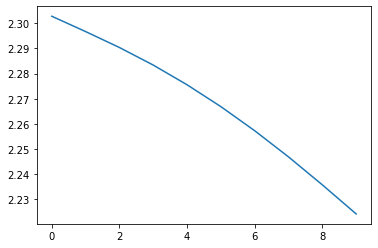

In [482]:
# let's look at the loss history!
plt.plot(loss_history)

In [484]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, t, epochs=100, learning_rate=2e-1, batch_size=300, reg=1e-1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.204
loss =  inf
grad =  [[-2.35999177e-04 -2.32972566e-02  1.52245110e-02 ...  2.09853323e-04
   4.22970840e-05  1.03166368e-03]
 [-5.12978158e-04 -2.29793589e-02  1.37090537e-02 ...  3.07051614e-04
  -1.16763576e-04  7.75843135e-04]
 [-9.89616340e-04 -2.05258358e-02  1.11712501e-02 ...  1.31159664e-04
  -1.43361411e-04  2.61873630e-04]
 ...
 [-1.06422049e-03 -2.45532675e-03  1.26021741e-03 ... -6.46929624e-04
   3.01945080e-04  2.92971519e-04]
 [-3.92619206e-04  8.52159652e-05 -2.17028038e-03 ... -3.55402384e-04
   5.73527389e-04  3.52836873e-04]
 [-6.42484392e-02  4.36561957e-01  2.46738706e-02 ... -6.99317618e-02
  -6.75069911e-02 -6.30150614e-02]]
Epoch 0, loss: inf


KeyboardInterrupt: 

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [497]:
num_epochs = 10
batch_size = 300

learning_rates = [1e-0, 1e-1, 1e-2]
reg_strengths = [1e-0, 1e-1, 1e-2]

best_classifier = None
best_val_accuracy = 0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

train_folds_X = np.split(train_X,5)
sub_train_folds_X = np.delete(train_folds_X, 4, 0)
sub_train_folds_X = np.concatenate(sub_train_folds_X)
sub_val_folds_X = train_folds_X[4]

train_folds_y = np.split(train_y, 5)
sub_train_folds_y = np.delete(train_folds_y, 4, 0)
sub_train_folds_y = np.concatenate(sub_train_folds_y)
sub_val_folds_y = train_folds_y[4]

sub_train_folds_y_t = np.zeros((sub_train_folds_y.shape[0],1), dtype=np.int)
for elem in range(sub_train_folds_y.shape[0]):
    sub_train_folds_y_t[elem] = sub_train_folds_y[elem]
    
sub_val_folds_y_t = np.zeros((sub_val_folds_y.shape[0],1), dtype=np.int)
for elem in range(sub_val_folds_y_t.shape[0]):
    sub_val_folds_y_t[elem] = sub_val_folds_y_t[elem]    

    
for l_r in learning_rates:
    for r_s in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        loss_history = classifier.fit(sub_train_folds_X, sub_train_folds_y_t, epochs=num_epochs, learning_rate=l_r, batch_size=batch_size, reg=r_s)
        
        pred = classifier.predict(sub_val_folds_X)
        accuracy = multiclass_accuracy(pred, sub_val_folds_y_t)
        
        print("learning_rates = {}, reg_strengths = {}, Accuracy: {}".format(l_r, r_s, accuracy))
        if best_val_accuracy < accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier

print('best validation accuracy achieved: %f' % best_val_accuracy)

loss =  2.3026664351476347
grad =  [[-7.07159174e-04 -4.35532073e-05 -1.20645065e-03 ... -6.75063893e-04
   8.99972729e-04  9.26281262e-04]
 [-1.26409907e-03  6.54991442e-04 -3.84528283e-04 ... -7.55991520e-04
   7.03502178e-04  5.27919392e-04]
 [-1.83774248e-03  1.35013612e-03  3.38055087e-04 ... -1.09223467e-03
   4.05761442e-04 -4.67081538e-05]
 ...
 [-3.17986993e-04 -1.45806173e-04  8.42750052e-04 ...  3.11870662e-05
   9.88495180e-04 -2.19547564e-05]
 [ 5.51819953e-04 -1.64467601e-03  7.10617577e-04 ...  5.70642812e-06
   1.11642312e-03 -3.39877064e-05]
 [ 2.81652192e-02 -8.86103845e-02 -4.72354835e-02 ...  2.50071930e-02
   3.15749375e-02  3.73917085e-02]]
Epoch 0, loss: 2.302666
loss =  2.2883546157066057
grad =  [[ 2.23044485e-03  8.72234396e-04  3.56267821e-03 ...  2.01543086e-03
  -3.78504123e-03 -2.00612373e-03]
 [ 1.82014834e-03  1.59354737e-03  4.40172331e-03 ...  2.08419086e-03
  -4.08332786e-03 -2.45507488e-03]
 [ 1.36883874e-03  2.43243107e-03  5.06364089e-03 ...  1.893

/home/pirozhochek/dl_tutorials/dlcourse_ai/assignments/assignment1/linear_classifer.py:57: RuntimeWarning: divide by zero encountered in log
  log_likelihood[i] = -np.log(p[i,target_index[i]])


loss =  inf
grad =  [[ 0.00866414 -0.01825612 -0.0058128  ...  0.00734653  0.00060583
  -0.00393358]
 [ 0.00906439 -0.01726175 -0.00969099 ...  0.00808069  0.00056966
  -0.00369665]
 [ 0.00917525 -0.01485247 -0.01453567 ...  0.00827573  0.00070694
  -0.00361127]
 ...
 [ 0.00304854 -0.00459977 -0.01596716 ...  0.00622158  0.00108867
  -0.00273577]
 [ 0.0037929  -0.00114265 -0.02167449 ...  0.00688844  0.00150398
  -0.0025847 ]
 [-0.03189369  0.37482528  0.01451096 ... -0.04685628 -0.06549735
  -0.04068785]]
Epoch 8, loss: inf
loss =  inf
grad =  [[ 0.00854072 -0.01814353 -0.00562854 ...  0.00733918  0.00060361
  -0.00398464]
 [ 0.00892859 -0.0171604  -0.00949764 ...  0.00806678  0.00057523
  -0.00374402]
 [ 0.00903658 -0.01477481 -0.01432255 ...  0.00825944  0.00072497
  -0.00365328]
 ...
 [ 0.00292567 -0.00436419 -0.01581747 ...  0.00620668  0.00109874
  -0.00279413]
 [ 0.00366955 -0.00092147 -0.02151996 ...  0.00684867  0.00153531
  -0.00263764]
 [-0.03231224  0.37542753  0.01424472 .

loss =  2.289423318718708
grad =  [[ 0.00315894  0.00182217  0.00237485 ...  0.00242281 -0.0041707
  -0.00128078]
 [ 0.00279045  0.00257252  0.00320654 ...  0.00249893 -0.00449802
  -0.00171693]
 [ 0.00237505  0.00346153  0.00388822 ...  0.0022917  -0.00486523
  -0.00230108]
 ...
 [ 0.00309467  0.00235502  0.00401984 ...  0.0030507  -0.00423422
  -0.00192058]
 [ 0.00408087  0.00110897  0.00387693 ...  0.00314483 -0.00415712
  -0.0019475 ]
 [ 0.02663134 -0.08048558 -0.042075   ...  0.02263906  0.03265827
   0.03293579]]
Epoch 1, loss: 2.289423
loss =  2.6877131010430335
grad =  [[-0.01360442 -0.00927953 -0.01207984 ... -0.00974776  0.02536523
   0.00438257]
 [-0.01452821 -0.00899722 -0.01191736 ... -0.01008021  0.02633271
   0.00415215]
 [-0.01539286 -0.00850075 -0.01184899 ... -0.01062082  0.02700653
   0.00374468]
 ...
 [-0.0135155  -0.00873761 -0.01061619 ... -0.00899927  0.02468594
   0.0037928 ]
 [-0.01299761 -0.01024228 -0.01126969 ... -0.00919638  0.02575746
   0.0039018 ]
 [ 0.0

loss =  2.42554285211045
grad =  [[ 0.0073452   0.00381202  0.00162173 ...  0.0069722  -0.007977
  -0.00032426]
 [ 0.0070488   0.00499171  0.0025286  ...  0.00733928 -0.00848235
  -0.00060932]
 [ 0.00627178  0.00676178  0.00372883 ...  0.00728948 -0.00910513
  -0.00113728]
 ...
 [ 0.00652365  0.00910586  0.00222267 ...  0.00232437 -0.00617666
  -0.00262586]
 [ 0.00716259  0.0094629   0.00240594 ...  0.00299349 -0.00652341
  -0.00284724]
 [ 0.01909965 -0.02906683 -0.04413547 ...  0.02399083  0.02906484
   0.02337753]]
Epoch 4, loss: 2.425543
loss =  3.558390048700029
grad =  [[ 0.01018532  0.00520043  0.00355623 ...  0.01188602 -0.01333777
  -0.00052625]
 [ 0.00999426  0.00688189  0.00451231 ...  0.01255091 -0.01395485
  -0.00074742]
 [ 0.00901467  0.00968225  0.00598678 ...  0.01257754 -0.01473678
  -0.00130038]
 ...
 [ 0.00894653  0.01611512  0.0020319  ...  0.00215254 -0.01056125
  -0.00349976]
 [ 0.00927253  0.01890581  0.00232791 ...  0.00324655 -0.01135269
  -0.00393426]
 [-0.0026

loss =  2.268580948239485
grad =  [[-4.08979083e-05 -2.17485783e-04 -1.43747561e-04 ... -1.90136290e-04
  -9.82036666e-05  2.90900555e-04]
 [-5.34306585e-04  4.55045119e-04  5.64017642e-04 ... -1.79570789e-04
  -2.77178425e-04 -5.08592222e-05]
 [-1.05120918e-03  1.26737766e-03  1.13660900e-03 ... -4.35747332e-04
  -5.25153912e-04 -5.78460222e-04]
 ...
 [-5.27570261e-05  3.16198552e-04  1.52838899e-03 ...  5.48660747e-04
  -2.07547129e-04 -4.14787980e-04]
 [ 8.40080220e-04 -9.81199747e-04  1.27608231e-03 ...  6.12293659e-04
  -4.01947344e-05 -3.80611396e-04]
 [ 2.46038583e-02 -7.65265129e-02 -4.13674121e-02 ...  2.18694282e-02
   2.73993938e-02  3.25743265e-02]]
Epoch 7, loss: 2.268581
loss =  2.260736423702176
grad =  [[-1.30050485e-05 -3.20580301e-04 -8.20454112e-05 ... -1.91203082e-04
  -1.25418442e-04  2.69727556e-04]
 [-4.95855406e-04  3.40097836e-04  5.82024971e-04 ... -1.63446966e-04
  -2.90419093e-04 -5.30554095e-05]
 [-1.00469550e-03  1.17337543e-03  1.10288833e-03 ... -4.04486

loss =  2.2762170656611804
grad =  [[-1.97930747e-04 -1.75842282e-04 -4.31987605e-04 ... -2.32336044e-04
   1.47783012e-04  4.15210508e-04]
 [-7.09624387e-04  4.92763869e-04  3.05914744e-04 ... -2.60819903e-04
  -3.89355856e-05  5.15309016e-05]
 [-1.23963923e-03  1.26267755e-03  9.15382032e-04 ... -5.62463812e-04
  -2.95429655e-04 -4.70598943e-04]
 ...
 [-1.04975822e-04  1.77249439e-04  1.30446451e-03 ...  4.12690458e-04
   1.38559716e-04 -2.93737017e-04]
 [ 7.76301252e-04 -1.18132341e-03  1.09227160e-03 ...  4.20763068e-04
   3.09889487e-04 -2.62023663e-04]
 [ 2.51989574e-02 -8.01409505e-02 -4.26184638e-02 ...  2.24585771e-02
   2.85352940e-02  3.38932283e-02]]
Epoch 9, loss: 2.276217
learning_rates = 0.1, reg_strengths = 0.01, Accuracy: 0.014444444444444444
loss =  2.3024525632478094
grad =  [[-9.74825442e-04 -1.19135853e-04 -1.02045739e-03 ... -8.60933595e-04
   1.16988790e-03  9.50558786e-04]
 [-1.53635482e-03  5.68931640e-04 -1.78750036e-04 ... -9.54731284e-04
   9.80336552e-04  5

loss =  2.302188308997305
grad =  [[-7.35533751e-04  7.72511710e-05 -1.20831390e-03 ... -6.68186649e-04
   9.68841019e-04  1.02432602e-03]
 [-1.28525987e-03  7.80417307e-04 -3.79943712e-04 ... -7.45858942e-04
   7.72000852e-04  6.26507251e-04]
 [-1.85740397e-03  1.48205467e-03  3.44565114e-04 ... -1.08373658e-03
   4.77658504e-04  6.04157426e-05]
 ...
 [-3.19319370e-04  1.61139764e-05  7.84417899e-04 ...  2.64611200e-05
   1.06102584e-03  4.35653037e-05]
 [ 5.49686938e-04 -1.47863534e-03  6.53872695e-04 ... -5.70382865e-06
   1.19727247e-03  4.49761106e-05]
 [ 2.81695792e-02 -8.85844688e-02 -4.72974990e-02 ...  2.50391166e-02
   3.15749621e-02  3.76484761e-02]]
Epoch 2, loss: 2.302188
loss =  2.3017781140041222
grad =  [[-6.87676198e-04  1.04863824e-04 -1.16892718e-03 ... -6.14464789e-04
   9.03783470e-04  9.88589785e-04]
 [-1.23404516e-03  8.09118473e-04 -3.41823437e-04 ... -6.88320902e-04
   7.05646177e-04  5.89777156e-04]
 [-1.80478018e-03  1.51165311e-03  3.79156483e-04 ... -1.0221

loss =  2.3012098925535276
grad =  [[-5.54414263e-04 -9.28648349e-05 -9.53560429e-04 ... -6.66937017e-04
   8.86947171e-04  8.42762178e-04]
 [-1.10220354e-03  5.95143604e-04 -1.15369402e-04 ... -7.47326576e-04
   6.87116496e-04  4.38982388e-04]
 [-1.66142998e-03  1.28702992e-03  6.36288388e-04 ... -1.09899099e-03
   3.74045065e-04 -1.49913427e-04]
 ...
 [-1.47810582e-04 -1.16805832e-04  1.09354800e-03 ...  3.23035587e-05
   9.15739947e-04 -1.03394780e-04]
 [ 7.30841394e-04 -1.61745581e-03  9.88215782e-04 ... -6.80013980e-06
   1.02851115e-03 -1.22873456e-04]
 [ 2.78373495e-02 -8.82591952e-02 -4.71245049e-02 ...  2.49392190e-02
   3.13574500e-02  3.74913203e-02]]
Epoch 4, loss: 2.301210
loss =  2.300855545324448
grad =  [[-5.30011577e-04 -8.20975316e-05 -9.24025843e-04 ... -6.37350222e-04
   8.40030665e-04  8.15892578e-04]
 [-1.07651899e-03  6.06094640e-04 -8.62356318e-05 ... -7.16105007e-04
   6.39042421e-04  4.11704913e-04]
 [-1.63454066e-03  1.29931992e-03  6.64611059e-04 ... -1.0664

# Какой же точности мы добились на тестовых данных?

In [500]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.096000
